In [ ]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import linregress
from matplotlib.patches import Rectangle
from plot import load_logs, plot_runs, add_values_from_normal_runs, PV_MAP
# refresh files

%load_ext autoreload
%autoreload 2

In [ ]:
TUM_colors =  {
    "TUMBlue": "#0065BD",
    "TUMSecondaryBlue": "#005293",
    "TUMSecondaryBlue2": "#003359",
    "TUMBlack": "#000000",
    "TUMWhite": "#FFFFFF",
    "TUMDarkGray": "#333333",
    "TUMGray": "#808080",
    "TUMLightGray": "#CCCCC6",
    "TUMAccentGray": "#DAD7CB",
    "TUMAccentOrange": "#E37222",
    "TUMAccentGreen": "#A2AD00",
    "TUMAccentLightBlue": "#98C6EA",
    "TUMAccentBlue": "#64A0C8"
}

In [ ]:
BASE_DIR = "/home/getznerj/Documents/Thesis/Thesis Final Experiments"

In [ ]:
def plot_data(
        data,
        log_dir,
        secondary_color_at=None,
        secondary_color_legend_text="",
        override_insignificance=False,
        legend_outside=False
):
    # split data into two dicts, one where keys contain nonDP and the others
    data_nonDP = {key: dataset for key, dataset in data.items() if "noDP" in key}
    data_DP = {key: dataset for key, dataset in data.items() if "noDP" not in key}
    # order dicts by key
    data_nonDP = {k: data_nonDP[k] for k in sorted(data_nonDP)}
    data_DP = {k: data_DP[k] for k in sorted(data_DP)}
    for data_dict in [data_nonDP,data_DP]:
        for idx, (df_name, df) in enumerate(data_dict.items()):
            fig, axes = plt.subplots(1, 1, figsize=(5.78853, 3), sharey="row", sharex="col")
            fontSize = 11
            rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': fontSize, 'axes.titlesize': fontSize, 'font.size': fontSize, 'legend.fontsize': fontSize*0.6}
            plt.rcParams.update(rc)
            pv = "age" if "age" in df_name else "sex"
            metrics = [col for col in df.columns if "subgroupAUROC" in col]
            df = df[["protected_attr", "protected_attr_percent", "seed"] + metrics]
            df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
            protected_attrs_to_plot = [np.round(k,2) for k in np.arange(0, 1.1, 0.1)] + [0.25,0.75]
            df = df.loc[df["protected_attr_percent"].isin(protected_attrs_to_plot)]
            #df = df.loc[df["protected_attr_percent"] == 0.5]
            metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
            g = plot_runs(df, metrics, pv, secondary_color_at=secondary_color_at, secondary_color_legend_text=secondary_color_legend_text, override_insignificance=override_insignificance, ax=axes, font_size=fontSize, legend_outside=legend_outside)
            # remove x label if idx == 0
            plt.tight_layout()
            plt.show()
            fig.savefig(f"../plots/{log_dir}/{pv}_{'DP' if not 'noDP' in df_name else 'no-DP'}.png", bbox_inches="tight")

In [ ]:
def compute_performance_gaps(data):
    for df_name, df in data.items():
        metrics = [col for col in df.columns if "subgroupAUROC" in col]
        pv = "age" if "age" in df_name else "sex"
        dp = False if "noDP" in df_name else True
        df_temp = df[["protected_attr", "protected_attr_percent"] + [col for col in df.columns if "subgroupAUROC" in col]]
        # compute mean performance at each protected attribute percentage
        df_temp = df_temp.groupby(["protected_attr","protected_attr_percent"]).mean().reset_index()
        df_temp = df_temp.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
        df_temp["performance_gap"] = abs(df_temp[PV_MAP[pv][1]] - df_temp[PV_MAP[pv][0]])*100
        # print(f"{'DP' if dp else 'No-DP'}: Mean performance gap for {pv}: {df_temp['performance_gap'].mean()}")
        print(f"{'DP' if dp else 'No-DP'} with {pv}:")
        print("worst case performance gap: ", df_temp["performance_gap"].max())
        print("mean performance gap: ", df_temp["performance_gap"].mean())

In [ ]:
def get_latex_table(df, df_dp, pv, group_by = "protected_attr_percent"):
    metrics = [col for col in df.columns if "subgroupAUROC" in col]
    df = df[[group_by] + [col for col in df.columns if "subgroupAUROC" in col]]
    df_dp = df_dp[[group_by] + [col for col in df_dp.columns if "subgroupAUROC" in col]]
    df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
    df_dp = df_dp.rename(columns={metric: PV_MAP[pv][1]+"_DP" if PV_MAP[pv][1] in metric else PV_MAP[pv][0]+"_DP" for metric in metrics})
    # group by protected attribute percentage and compute mean and std
    df = df.groupby(group_by).aggregate(["mean", "std"]).reset_index()
    df_dp = df_dp.groupby(group_by).aggregate(["mean", "std"]).reset_index()
    # join on protected attribute percentage
    df = df.merge(df_dp, on=group_by, how="left").reset_index()
    # make multiindex to str
    df.columns = ["/".join(col) for col in df.columns]
    
    group_a = PV_MAP[pv][0]
    group_b = PV_MAP[pv][1]
    for idx, row in df.iterrows():
        if group_by == "protected_attr_percent" and (row["protected_attr_percent/"]*100 % 10 != 0) and not (row["protected_attr_percent/"] in [0.25,0.75]):
            continue
        a_mean = np.round(row[f"{group_a}/mean"]*100,2)
        a_std = np.round(row[f"{group_a}/std"]*100,2)
        a_mean_dp = np.round(row[f"{group_a}_DP/mean"]*100,2) if not np.isnan(row[f"{group_a}_DP/mean"]) else ""
        a_std_dp = np.round(row[f"{group_a}_DP/std"]*100,2) 
        b_mean = np.round(row[f"{group_b}/mean"]*100,2)
        b_std = np.round(row[f"{group_b}/std"]*100,2)
        b_mean_dp = np.round(row[f"{group_b}_DP/mean"]*100,2) if not np.isnan(row[f"{group_b}_DP/mean"]) else ""
        b_std_dp = np.round(row[f"{group_b}_DP/std"]*100,2)
        mean_diff = abs(np.round((a_mean - b_mean),2))
        mean_diff_dp = abs(np.round((a_mean_dp - b_mean_dp),2)) if a_mean_dp !="" else "/"
        
        a_mean = '{:.2f}'.format(a_mean)
        a_std = '{:.2f}'.format(a_std)
        a_mean_dp = '{:.2f}'.format(a_mean_dp) if a_mean_dp != '' else ''
        a_std_dp = '{:.2f}'.format(a_std_dp) if a_mean_dp != '' else ''
        b_mean = '{:.2f}'.format(b_mean)
        b_std = '{:.2f}'.format(b_std)
        b_mean_dp = '{:.2f}'.format(b_mean_dp) if b_mean_dp != '' else ''
        b_std_dp = '{:.2f}'.format(b_std_dp) if b_mean_dp != '' else ''
        mean_diff = '{:.2f}'.format(mean_diff)
        mean_diff_dp = '{:.2f}'.format(mean_diff_dp) if mean_diff_dp != '/' else '/'
        indicator = str(int(row[f'{group_by}/']*100))+"\%" if group_by == "protected_attr_percent" else row[f'{group_by}/']
        template = f"{indicator} & {a_mean}\std{{{a_std if a_mean != '' else ''}}} & {a_mean_dp}\std{{{a_std_dp if a_mean_dp != '' else ''}}} & {b_mean}\std{{{b_std}}} & {b_mean_dp}\std{{{b_std_dp if b_mean_dp != '' else ''}}} & {mean_diff} & {mean_diff_dp} \\\ \hline"
        template = template.replace("\std{}", "/")
        print(template)

# Baseline

In [ ]:
log_dir = os.path.join(BASE_DIR, "baseline")
data = load_logs(log_dir = log_dir)

In [ ]:
plot_data(data, "baseline")

In [ ]:
# get sex age dfs
data_age = {key:value for key,value in data.items() if "age" in key}
data_sex = {key:value for key,value in data.items() if "sex" in key}

In [ ]:
df_collection = data_sex
df = [value for key, value in df_collection.items() if "noDP" in key][0]
df_dp = [value for key, value in df_collection.items() if not "noDP" in key][0]
pv = "sex"
get_latex_table(df,df_dp,pv)

In [ ]:
compute_performance_gaps(data)

# Up-Sampling

In [ ]:
log_dir = os.path.join(BASE_DIR, "upsampling")
data = load_logs(log_dir = log_dir)
data = add_values_from_normal_runs(BASE_DIR, data, 0.5)

In [ ]:
plot_data(data, log_dir="upsampling", secondary_color_at=50, secondary_color_legend_text="balanced - no upsampling")

In [ ]:
# get sex age dfs
data_age = {key:value for key,value in data.items() if "age" in key}
data_sex = {key:value for key,value in data.items() if "sex" in key}

In [ ]:
df_collection = data_age
df = [value for key, value in df_collection.items() if "noDP" in key][0]
df_dp = [value for key, value in df_collection.items() if not "noDP" in key][0]
pv = "age"
get_latex_table(df,df_dp,pv)

In [ ]:
compute_performance_gaps(data)

# Loss Weighting

In [ ]:
log_dir = os.path.join(BASE_DIR, "loss_weighing")
data = load_logs(log_dir = log_dir)

In [ ]:
def get_values_from_normal_runs(data_outer, split):
    data_normal = load_logs(log_dir = os.path.join(BASE_DIR, "baseline"))
    new_rows = {}
    for key, df_normal in data_normal.items():
        pv = "age" if "age" in key else "sex"
        dp = False if "noDP" in key else True
        corresponding_outer_keys = [k for k in data_outer.keys() if pv in k and ((not dp) == ("noDP" in k))]
        if corresponding_outer_keys == []:
            continue
        else:
            corresponding_outer_key = corresponding_outer_keys[0]
        rows = df_normal[df_normal["protected_attr_percent"] == split]
        new_rows[corresponding_outer_key] = rows
    return new_rows

In [ ]:
data_weight_1 = get_values_from_normal_runs(data, 0.5)
for key, dataset in data_weight_1.items():
    dataset["weight"] = 1
    data[key] = pd.concat([data[key], dataset])

In [ ]:
for key, dataset in data.items():
    fig, axes = plt.subplots(1, 1, figsize=(5.78853, 3), sharey="row", sharex="col")
    font_size = 11
    rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': font_size, 'axes.titlesize': font_size, 'font.size': font_size, 'legend.fontsize': font_size*0.8}
    plt.rcParams.update(rc)
    dataset = dataset.loc[dataset["protected_attr_percent"] == 0.5]
    pv = "age" if "age" in key else "sex"
    metrics = [col for col in dataset.columns if "subgroupAUROC" in col]
    df = dataset[["protected_attr", "protected_attr_percent", "seed", "weight"] + metrics]
    # rename metrics
    df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
    metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
    axes = plot_runs(
        df,
        metrics,
        pv,
        secondary_color_at=1.0,
        secondary_color_legend_text="no weighing",
        x_var="weight",
        regress=False,
        ax=axes,
        font_size=font_size*0.8,
        ylim=0,
        legend_outside=True
    )
    fig.savefig(f"../plots/loss_weighing/{pv}_{'DP' if not 'noDP' in key else 'no-DP'}.png", bbox_inches="tight")

In [ ]:
# get sex age dfs
for key, dataset in data.items():
    data[key] = dataset.loc[dataset["protected_attr_percent"] == 0.5]
data_age = {key:value for key,value in data.items() if "age" in key}
data_sex = {key:value for key,value in data.items() if "sex" in key}

In [ ]:
df_collection = data_age
df = [value for key, value in df_collection.items() if "noDP" in key][0]
df_dp = [value for key, value in df_collection.items() if not "noDP" in key][0]
pv = "age"
get_latex_table(df,df_dp,pv, group_by="weight")

# Fine-Tuning

In [11]:
log_dir = os.path.join(BASE_DIR, "fine_tuning")
data = load_logs(log_dir = log_dir, fine_tuning=True)

Slope for old is 0.009 with p-value 0.006 
Slope for young is 0.001 with p-value 0.714 


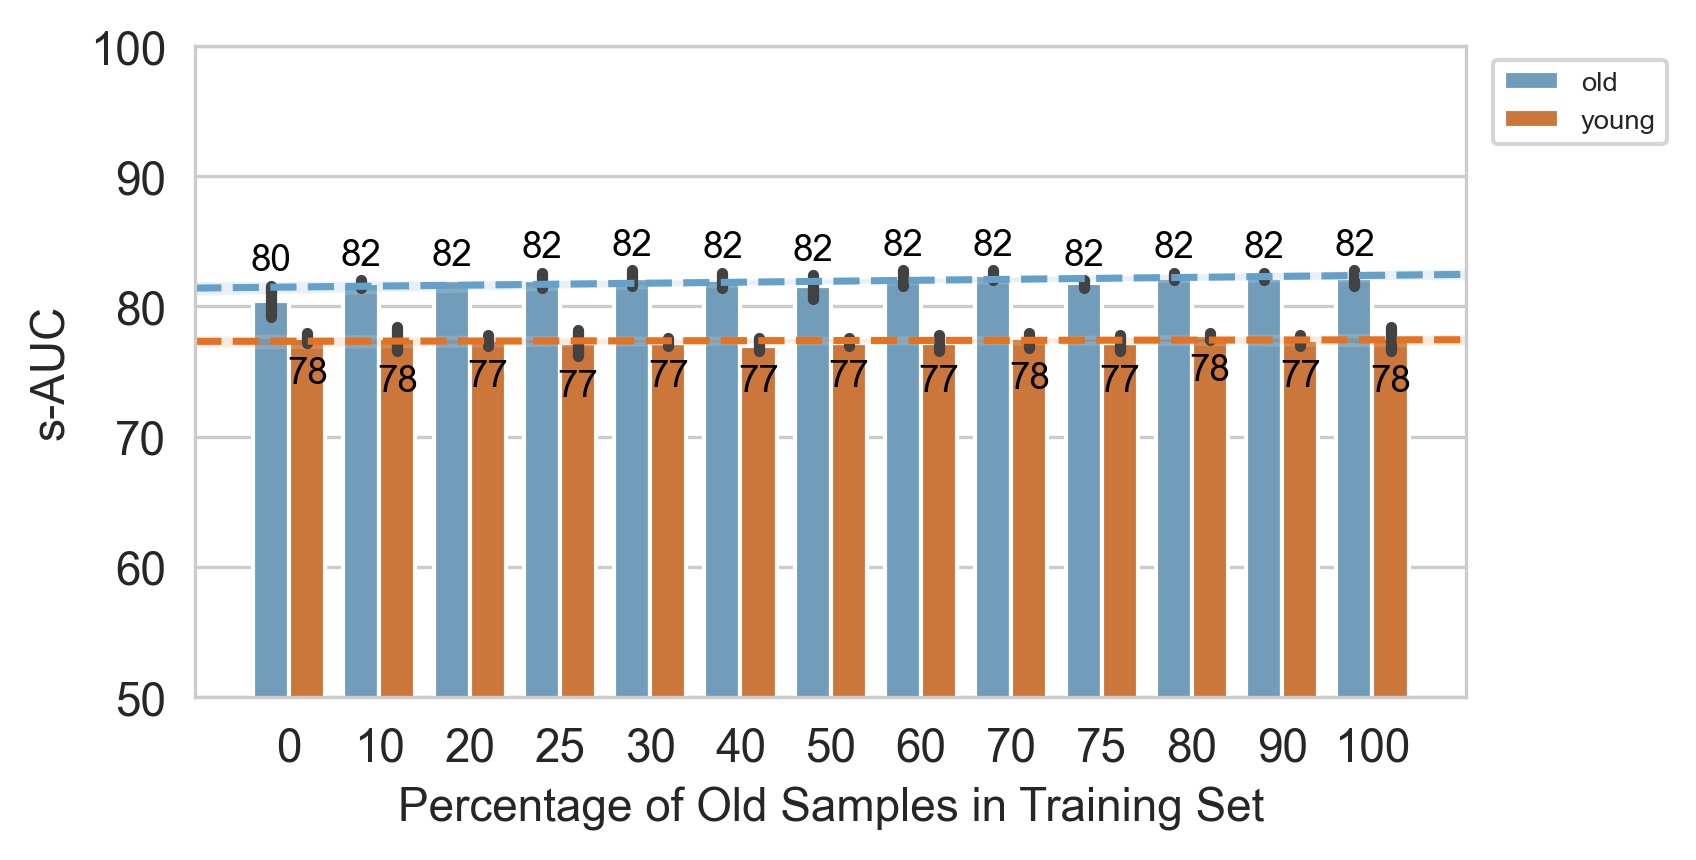

Slope for male is 0.014 with p-value 0.000 
Slope for female is -0.005 with p-value 0.152 


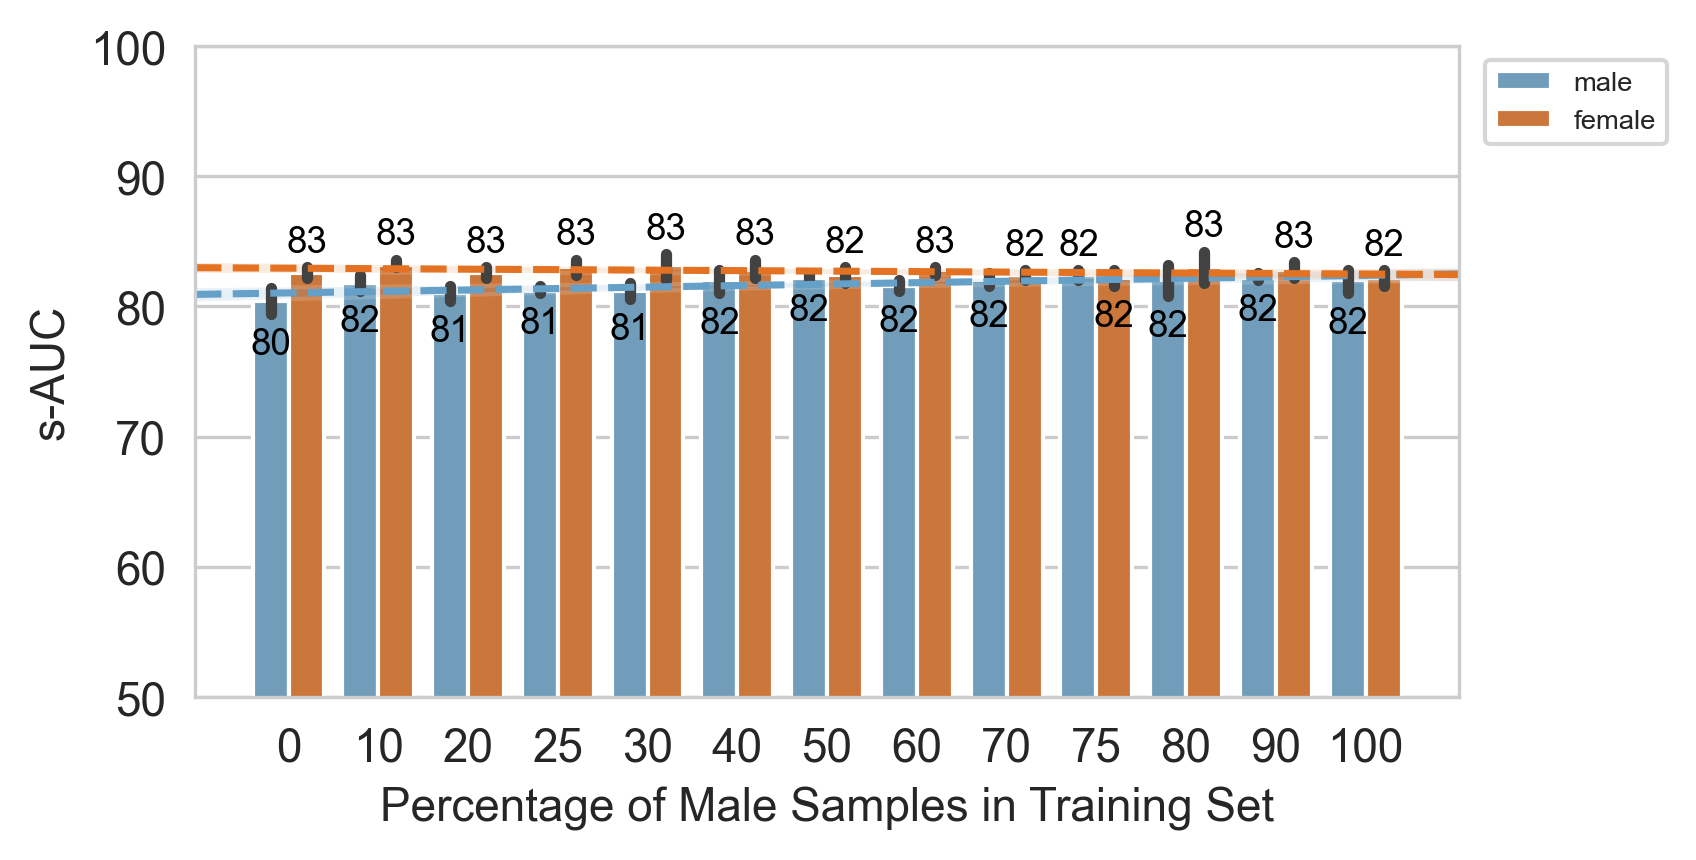

Slope for old is 0.017 with p-value 0.000 
Slope for young is -0.039 with p-value 0.000 


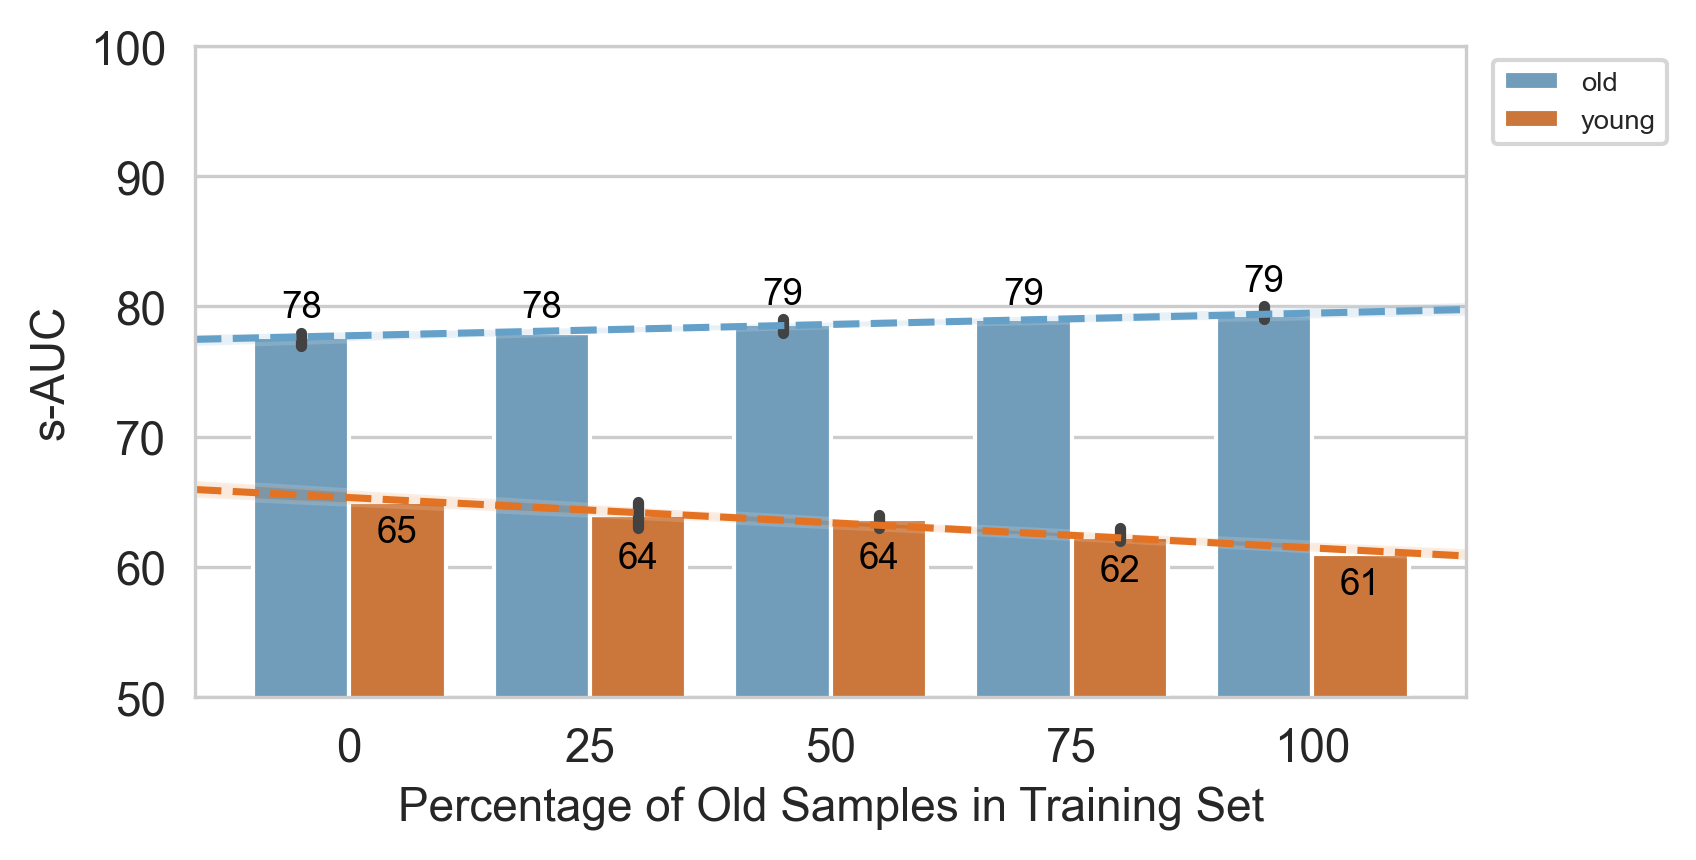

Slope for male is 0.077 with p-value 0.000 
Slope for female is -0.039 with p-value 0.000 


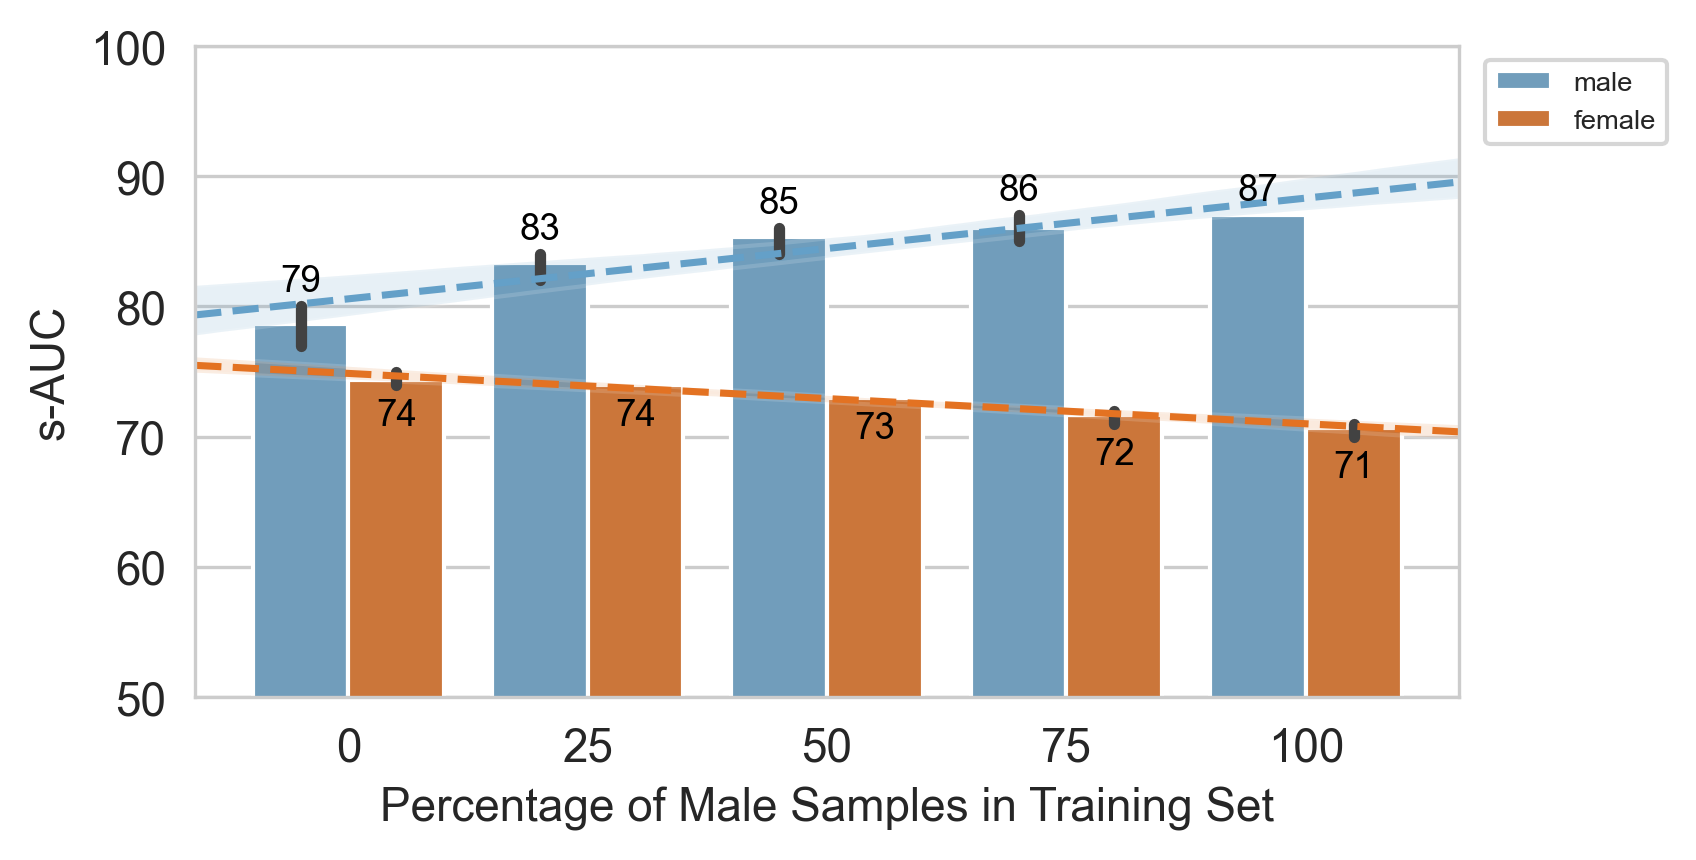

In [12]:
plot_data(data,log_dir="fine_tuning", override_insignificance=True, legend_outside=True)

In [13]:
data_age = {key:value for key,value in data.items() if "age" in key}
data_sex = {key:value for key,value in data.items() if "sex" in key}

In [14]:
df_collection = data_age
df = [value for key, value in df_collection.items() if "noDP" in key][0]
df_dp = [value for key, value in df_collection.items() if not "noDP" in key][0]
pv = "age"
get_latex_table(df,df_dp,pv)

0\% & 81.14\std{1.31} & 78.08\std{0.47} & 78.10\std{0.49} & 65.59\std{0.30} & 3.04 & 12.49 \\ \hline
10\% & 82.12\std{0.47} & / & 78.12\std{0.88} & / & 4.00 & / \\ \hline
20\% & 82.41\std{0.38} & / & 77.72\std{0.55} & / & 4.69 & / \\ \hline
25\% & 82.65\std{0.84} & 78.58\std{0.39} & 77.67\std{1.08} & 64.57\std{0.77} & 4.98 & 14.01 \\ \hline
30\% & 82.71\std{0.75} & / & 77.78\std{0.68} & / & 4.93 & / \\ \hline
40\% & 82.46\std{0.46} & / & 77.31\std{0.80} & / & 5.15 & / \\ \hline
50\% & 82.04\std{0.90} & 79.03\std{0.32} & 77.75\std{0.71} & 64.11\std{0.52} & 4.29 & 14.92 \\ \hline
60\% & 82.48\std{0.69} & / & 77.64\std{0.86} & / & 4.84 & / \\ \hline
70\% & 83.12\std{0.45} & / & 77.88\std{0.72} & / & 5.24 & / \\ \hline
75\% & 82.23\std{0.44} & 79.75\std{0.28} & 77.52\std{0.78} & 62.99\std{0.55} & 4.71 & 16.76 \\ \hline
80\% & 82.59\std{0.48} & / & 78.24\std{0.64} & / & 4.35 & / \\ \hline
90\% & 82.52\std{0.38} & / & 78.04\std{0.53} & / & 4.48 & / \\ \hline
100\% & 82.78\std{0.71} & 80.11\s

/tmp/ipykernel_27127/980573936.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(df_dp, on=group_by, how="left").reset_index()


# Core Set Selection

In [ ]:
from matplotlib.font_manager import fontManager, FontProperties
path = "/home/getznerj/Downloads/Palatino Font Free/Palatino.ttf"
fontManager.addfont(path)
prop = FontProperties(fname=path)
plt.rcParams['font.family'] = prop.get_name()

In [ ]:
font_size = 11
rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': font_size, 'axes.titlesize': font_size, 'font.size': font_size, 'legend.fontsize': font_size*0.8}
plt.rcParams.update(rc)

In [ ]:
from matplotlib.lines import Line2D
metrics = (
    f"test/old_subgroupAUROC", f"test/young_subgroupAUROC",
    f"test/female_subgroupAUROC", f"test/male_subgroupAUROC"
)

In [ ]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        score_var = d.split("/")[-1].split("-")[0]
        dp = not "noDP" in d
        if dp:
            num_samples = int(d.split("/")[-1].split("-")[-1].split("_")[0])
        else:
            num_samples = int(d.split("/")[-1].split("-")[-1])
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')]
            for results_dir in results:
                results_df = pd.read_csv(os.path.join(d, seed, results_dir))
                results_df["score_var"] = score_var
                results_df["num_samples"] = num_samples
                dfs.append(results_df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
data_noDP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-11-09 20:06:05-FAE-rsna-balanced-subsetperformance-noDP/old_percent_05_bestBytest"))
data_noDP = data_noDP.loc[data_noDP.dataset == "rsna"]
data_DP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-12-07 16:22:58-FAE-rsna-balanced-subsetperformance-DP/old_percent_05_bestBytest"))
#data_age_DP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-12-08 14:17:02-FAE-rsna-old-age-subsetperformance-DP/old_percent_05_bestBytest"))
#data_sex_DP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-12-08 15:57:52-FAE-rsna-old-sex-subsetperformance-DP/male_percent_05_bestBytest"))

In [ ]:
plot_settings = {
    (0,0):  ("-",TUM_colors["TUMAccentBlue"]), 
    (0,1):  ("-",TUM_colors["TUMAccentOrange"]),
    (1,0):  ("--",TUM_colors["TUMAccentBlue"]), 
    (1,1):  ("--",TUM_colors["TUMAccentOrange"]),
}

In [ ]:
def plot_coresetselection(df_core_set, dp=False):
    df_core_set["value"] = df_core_set["value"]*100
    for pv in ["age", "sex"]:
        if pv == "age":
            score_vars = ["old_subgroupAUROC", "young_subgroupAUROC"]
            metrics = ["old", "young"]
        else:
            score_vars = ["male_subgroupAUROC", "female_subgroupAUROC"]
            metrics = ["male", "female"]
        fig, axes = plt.subplots(1, 1, figsize=(5.78853, 3), sharey="row", sharex="col")
        legend_elements = []
        for a, score_var in enumerate(score_vars):
            for b, metric in enumerate(metrics):
                data = df_core_set.loc[(df_core_set.score_var == score_var) & (df_core_set.metric == metric)]
                # print mean and std of each line
                # only 50 samples
                temp = data.loc[data.num_samples == 50]
                print(score_var)
                print(f"mean {metric}-AUC: {temp.value.mean()}", f"std {metric}-AUC: {temp.value.std()}")
                g = sns.lineplot(
                    data=data,
                    x="num_samples",
                    y="value",
                    color=plot_settings[(a,b)][1],
                    ls=plot_settings[(a,b)][0],
                    ax=axes
                )
                if "female" in score_var:
                    metric_name = "female"
                elif "young" in score_var:
                    metric_name = "young"
                elif "old" in score_var:
                    metric_name = "old"
                else:
                    metric_name = "male"
                legend_elements.append(Line2D([0], [0], color=plot_settings[(a,b)][1], linestyle=plot_settings[(a,b)][0], label=f"{metric} (best {metric_name})"))
            axes.legend(handles=legend_elements, title='Group', bbox_to_anchor=(1.0, 1.02), loc='upper left')    
            axes.set_ylim(30,100)
            #axes.set_title(f"best samples by {metric_name}-AUC")
            axes.set_ylabel("s-AUC")
            axes.set_xlabel("Number of Samples")
        plt.show()
        fig.savefig(f"../plots/core-set-selection/{pv}_{'no-DP' if not dp else 'DP'}.png", bbox_inches="tight")

# NoDP

In [ ]:
data_noDP = data_noDP[[*metrics, "dataset", "seed", "score_var","num_samples"]]
data_noDP = data_noDP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="metric", value_name="value")

In [ ]:
data_noDP = data_noDP.loc[data_noDP["score_var"] != "AUROC"]
data_noDP.metric = data_noDP.metric.str.replace("test/", "")
data_noDP.metric = data_noDP.metric.str.replace("_subgroupAUROC", "")
# remove num_samples=1 rows
data_noDP = data_noDP.loc[data_noDP.num_samples != 1]

In [ ]:
plot_coresetselection(data_noDP)

# DP

In [ ]:
data_DP = data_DP[[*metrics, "dataset", "seed", "score_var","num_samples"]]
data_DP = data_DP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="metric", value_name="value")

In [ ]:
data_DP = data_DP.loc[data_DP["score_var"] != "AUROC"]
data_DP.metric = data_DP.metric.str.replace("test/", "")
data_DP.metric = data_DP.metric.str.replace("_subgroupAUROC", "")
data_DP = data_DP.loc[data_DP.num_samples != 1]

In [ ]:
plot_coresetselection(data_DP, dp=True)

In [ ]:
#metrics_age = [f"test/old_subgroupAUROC", f"test/young_subgroupAUROC"]
#metrics_sex = [f"test/female_subgroupAUROC", f"test/male_subgroupAUROC"]
#data_age_DP.columns = [col.replace("lungOpacity_", "") for col in data_age_DP.columns]
#data_sex_DP.columns = [col.replace("lungOpacity_", "") for col in data_sex_DP.columns]

In [ ]:
#data_age_DP = data_age_DP[[*metrics_age, "dataset", "seed", "score_var","num_samples"]]
#data_sex_DP = data_sex_DP[[*metrics_sex, "dataset", "seed", "score_var","num_samples"]]

In [ ]:
#data_age_DP = data_age_DP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="metric", value_name="value")
#data_sex_DP = data_sex_DP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="metric", value_name="value")
#data_DP = pd.concat([data_age_DP,data_sex_DP], ignore_index=True, axis=0)

In [ ]:
#data_DP = data_DP.loc[data_DP["score_var"] != "AUROC"]
#data_DP.metric = data_DP.metric.str.replace("test/", "")
#data_DP.metric = data_DP.metric.str.replace("_subgroupAUROC", "")

In [ ]:
#plot_coresetselection(data_DP, dp=True)

In [ ]:
df = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-11-09 20:06:05-FAE-rsna-balanced-subsetperformance-noDP/old_percent_05_bestBytest"))
df = df.loc[df.dataset == "rsna"]
df_dp = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-12-07 16:22:58-FAE-rsna-balanced-subsetperformance-DP/old_percent_05_bestBytest"))

In [ ]:
metrics_age = ['test/young_subgroupAUROC','test/old_subgroupAUROC']
metrics_sex = ['test/male_subgroupAUROC','test/female_subgroupAUROC']

In [ ]:
score_var = "female_subgroupAUROC"
df = df.drop(columns=[col for col in df.columns if col.startswith("test") and col not in metrics_sex])
df_dp = df_dp.drop(columns=[col for col in df_dp.columns if col.startswith("test") and col not in metrics_sex])
df = df.loc[df.score_var == score_var]
df_dp = df_dp.loc[df_dp.score_var == score_var]

In [ ]:
pv = "sex"
get_latex_table(df,df_dp,pv, group_by="num_samples")